# Apprentissage par renforcement (TD)

## Q-learning : mise à jour hors-politique

In [28]:
# @markdown Execute to get helper functions `epsilon_greedy`, `CliffWorld`, and `learn_environment`

def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probability
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """
  if np.random.random() > epsilon:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q))

  return action


class CliffWorld:
  """
  World: Cliff world.
  40 states (4-by-10 grid world).
  The mapping from state to the grids are as follows:
  30 31 32 ... 39
  20 21 22 ... 29
  10 11 12 ... 19
  0  1  2  ...  9
  0 is the starting state (S) and 9 is the goal state (G).
  Actions 0, 1, 2, 3 correspond to right, up, left, down.
  Moving anywhere from state 9 (goal state) will end the session.
  Taking action down at state 11-18 will go back to state 0 and incur a
      reward of -100.
  Landing in any states other than the goal state will incur a reward of -1.
  Going towards the border when already at the border will stay in the same
      place.
  """
  def __init__(self):
    self.name = "cliff_world"
    self.n_states = 40
    self.n_actions = 4
    self.dim_x = 10
    self.dim_y = 4
    self.init_state = 0

  def get_outcome(self, state, action):
    if state == 9:  # goal state
      reward = 0
      next_state = None
      return next_state, reward
    reward = -1  # default reward value
    if action == 0:  # move right
      next_state = state + 1
      if state % 10 == 9:  # right border
        next_state = state
      elif state == 0:  # start state (next state is cliff)
        next_state = None
        reward = -100
    elif action == 1:  # move up
      next_state = state + 10
      if state >= 30:  # top border
        next_state = state
    elif action == 2:  # move left
      next_state = state - 1
      if state % 10 == 0:  # left border
        next_state = state
    elif action == 3:  # move down
      next_state = state - 10
      if state >= 11 and state <= 18:  # next is cliff
        next_state = None
        reward = -100
      elif state <= 9:  # bottom border
        next_state = state
    else:
      print("Action must be between 0 and 3.")
      next_state = None
      reward = None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes = {}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state, reward = self.get_outcome(state, action)
        outcomes[state, action] = [(1, next_state, reward)]
    return outcomes


def learn_environment(env, learning_rule, params, max_steps, n_episodes):
  # Start with a uniform value function
  value = np.ones((env.n_states, env.n_actions))

  # Run learning
  reward_sums = np.zeros(n_episodes)

  # Loop over episodes
  for episode in range(n_episodes):
    state = env.init_state  # initialize state
    reward_sum = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])

      # observe outcome of action on environment
      next_state, reward = env.get_outcome(state, action)

      # update value function
      value = learning_rule(state, action, reward, next_state, value, params)

      # sum rewards obtained
      reward_sum += reward

      if next_state is None:
          break  # episode ends
      state = next_state

    reward_sums[episode] = reward_sum

  return value, reward_sums

### A faire : complétez le code suivant qui est une implémentation  la méthode Q-learning 

In [29]:
def q_learning(state, action, reward, next_state, value, params):
  """Q-learning: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # Q-value of current state-action pair
  q = value[state, action]

  alpha = params["alpha"]
  gamma = params["gamma"]
  # write an expression for finding the maximum Q-value at the current state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state])
  # write the expression to compute the TD error
  td_error = reward + gamma * max_next_q - q
  # write the expression that updates the Q-value for the state-action pair
  value[state, action] = q + alpha * td_error

  return value


## tester la méthode

In [30]:
import numpy as np

In [31]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning = results

## l’affichage

In [32]:
# @title Plotting Functions

def plot_state_action_values(env, value, ax=None, show=False):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')
  if show:
    plt.show()


def plot_quiver_max_action(env, value, ax=None, show=False):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')
  if show:
    plt.show()


def plot_heatmap_max_val(env, value, ax=None, show=False):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1, :]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
    ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  if show:
    plt.show()
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None, show=False):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')
  if show:
    plt.show()


def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0, 0])
  plot_quiver_max_action(env, value, ax=axes[0, 1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1, 0])
  im = plot_heatmap_max_val(env, value, ax=axes[1, 1])
  fig.colorbar(im)
  plt.show(fig)

A faire : N'hésitez pas à modifier les paramètres ou la graine aléatoire et à observer comment le comportement de l'agent change.

In [33]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.2,  # epsilon-greedy policy
  'alpha': 0.05,  # learning rate
  'gamma': 0.9  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning = results

In [ ]:
# @title Plotting Functions

def plot_state_action_values(env, value, ax=None, show=False):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')
  if show:
    plt.show()


def plot_quiver_max_action(env, value, ax=None, show=False):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')
  if show:
    plt.show()


def plot_heatmap_max_val(env, value, ax=None, show=False):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1, :]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
    ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  if show:
    plt.show()
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None, show=False):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')
  if show:
    plt.show()


def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0, 0])
  plot_quiver_max_action(env, value, ax=axes[0, 1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1, 0])
  im = plot_heatmap_max_val(env, value, ax=axes[1, 1])
  fig.colorbar(im)
  plt.show(fig)

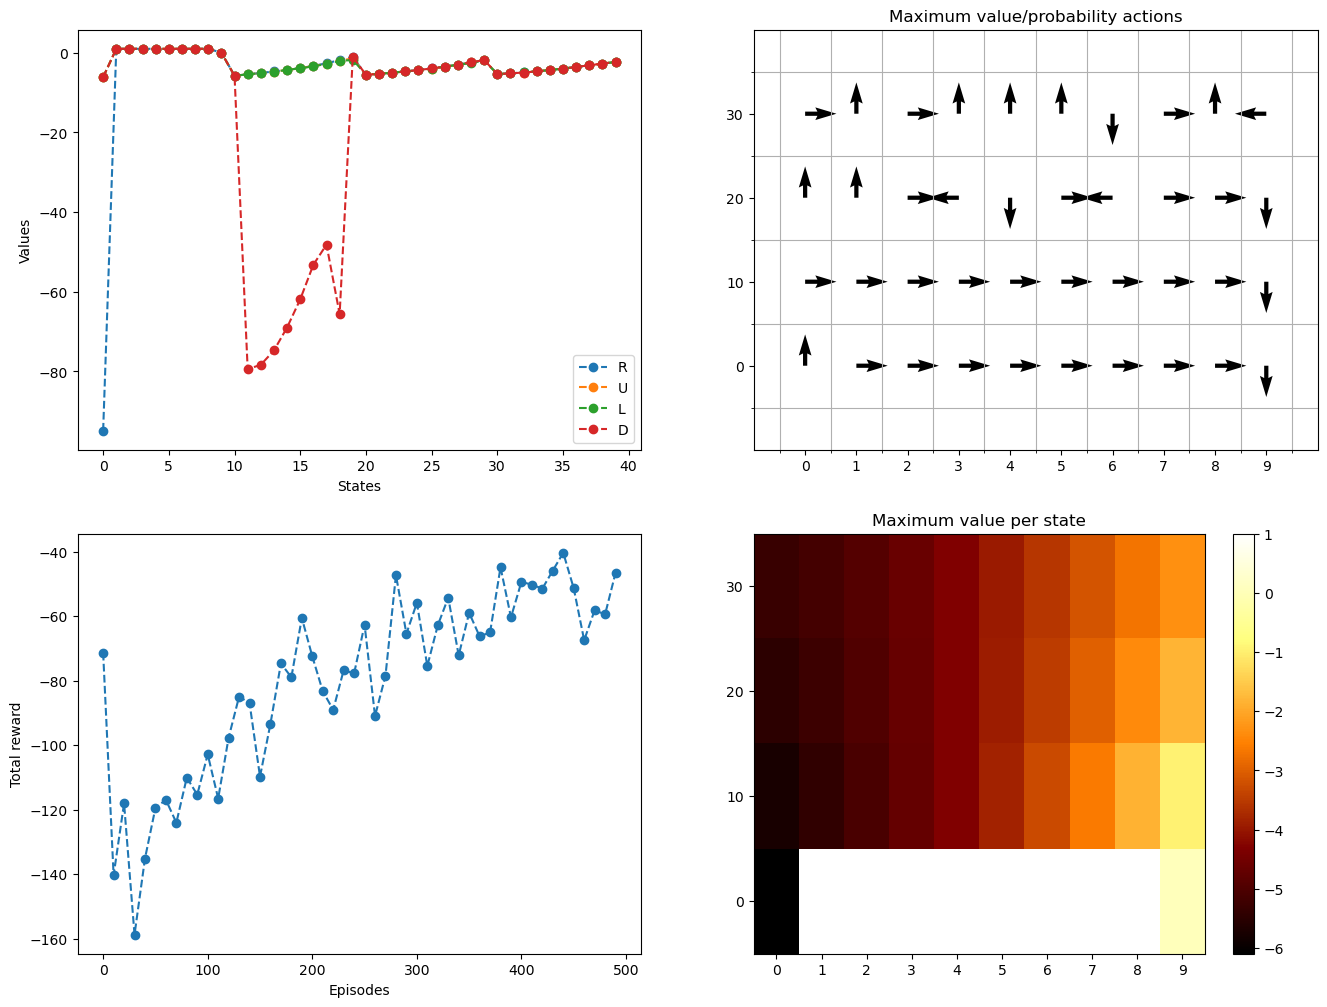

In [35]:
import numpy as np
import matplotlib.pyplot as plt

conv = np.convolve

plot_performance(env, value_qlearning, reward_sums_qlearning)


-epsilon:

Plus grand → plus d’exploration de teste davantage de chemins

Plus petit → plus d’exploitation suit plus vite la meilleure stratégie

-alpha: 

Grand → apprentissage rapide mais instable.

Petit → apprentissage lent mais plus stable.

-gamma :

Proche de 1 → l’agent prend en compte les récompenses futures.

Plus petit → l’agent privilégie les gains immédiats.

## Actor–Critic tabulaire

In [36]:
def learn_environment_actor_critic(env, learning_rule, params, max_steps, n_episodes):
    # Initialize value function (state-value function)
    value = np.zeros(env.n_states)

    # Initialize policy uniformly for each state
    # policy[s, a] = 1 / n_actions
    policy = np.ones((env.n_states, env.n_actions)) / env.n_actions

    # Store cumulative rewards
    reward_sums = np.zeros(n_episodes)

    # Loop over episodes
    for episode in range(n_episodes):
        state = env.init_state
        reward_sum = 0

        for t in range(max_steps):
            # Choose an action from the policy (multinomial)
            action = np.random.choice(env.n_actions, p=policy[state])

            # Observe transition
            next_state, reward = env.get_outcome(state, action)

            # Update both value and policy via actor-critic rule
            value, policy = learning_rule(
                state, action, reward, next_state, value, policy, params
            )

            # Accumulate rewards
            reward_sum += reward

            # Episode termination
            if next_state is None:
                break
            state = next_state

        reward_sums[episode] = reward_sum

    return value, policy, reward_sums

In [45]:
def actor_critic(state, action, reward, next_state, value, policy, params):
    """Actor-Critic tabulaire."""

    # Paramètres
    alpha_v = params["alpha_v"]
    alpha_pi = params["alpha_pi"]
    gamma = params["gamma"]

    # Critic
    v = value[state]
    v_next = 0 if next_state is None else value[next_state]
    delta = reward + gamma * v_next - v
    value[state] = v + alpha_v * delta

    # Actor update
    for a in range(policy.shape[1]):
        if a == action:
            grad = 1 - policy[state, a]
        else:
            grad = -policy[state, a]
        policy[state, a] += alpha_pi * delta * grad

    # Projection sur le simplexe pour éviter valeurs négatives
    policy[state] = np.maximum(policy[state], 1e-8)
    policy[state] /= policy[state].sum()

    return value, policy


A faire : 

#### Testez la méthode comme précédemment et affichez le résultat.

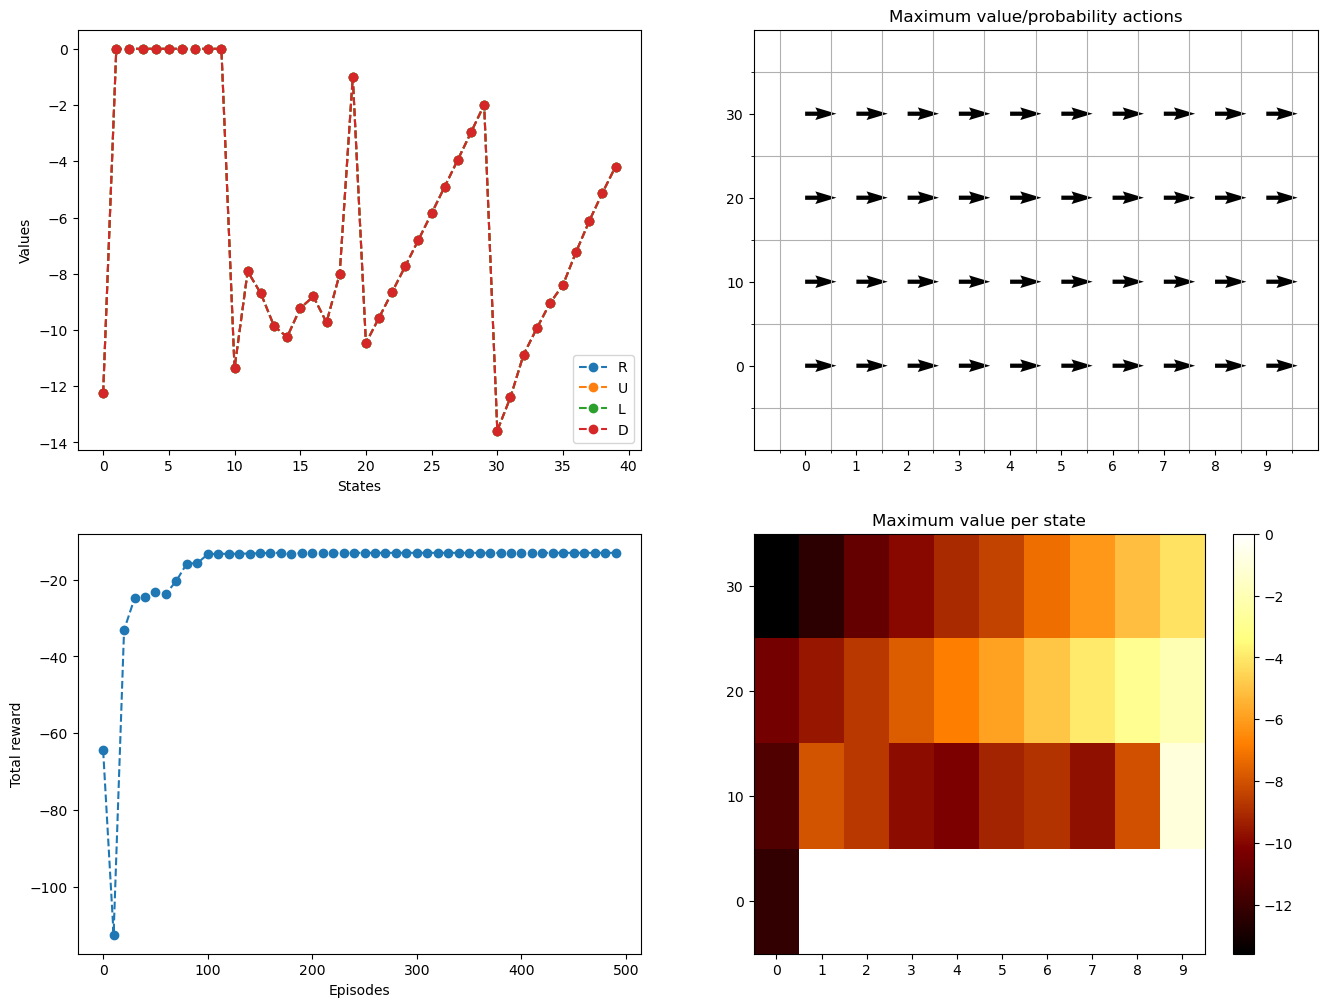

In [50]:
value_ac, policy_ac, reward_sums_ac = learn_environment_actor_critic(
    env,
    learning_rule=actor_critic,
    params=params_ac,
    max_steps=200,
    n_episodes=500
)
value_2d = np.tile(value_ac[:, np.newaxis], (1, env.n_actions))


plot_performance(env, value_2d, reward_sums_ac)


#### modifier les paramètres ou la graine aléatoire 

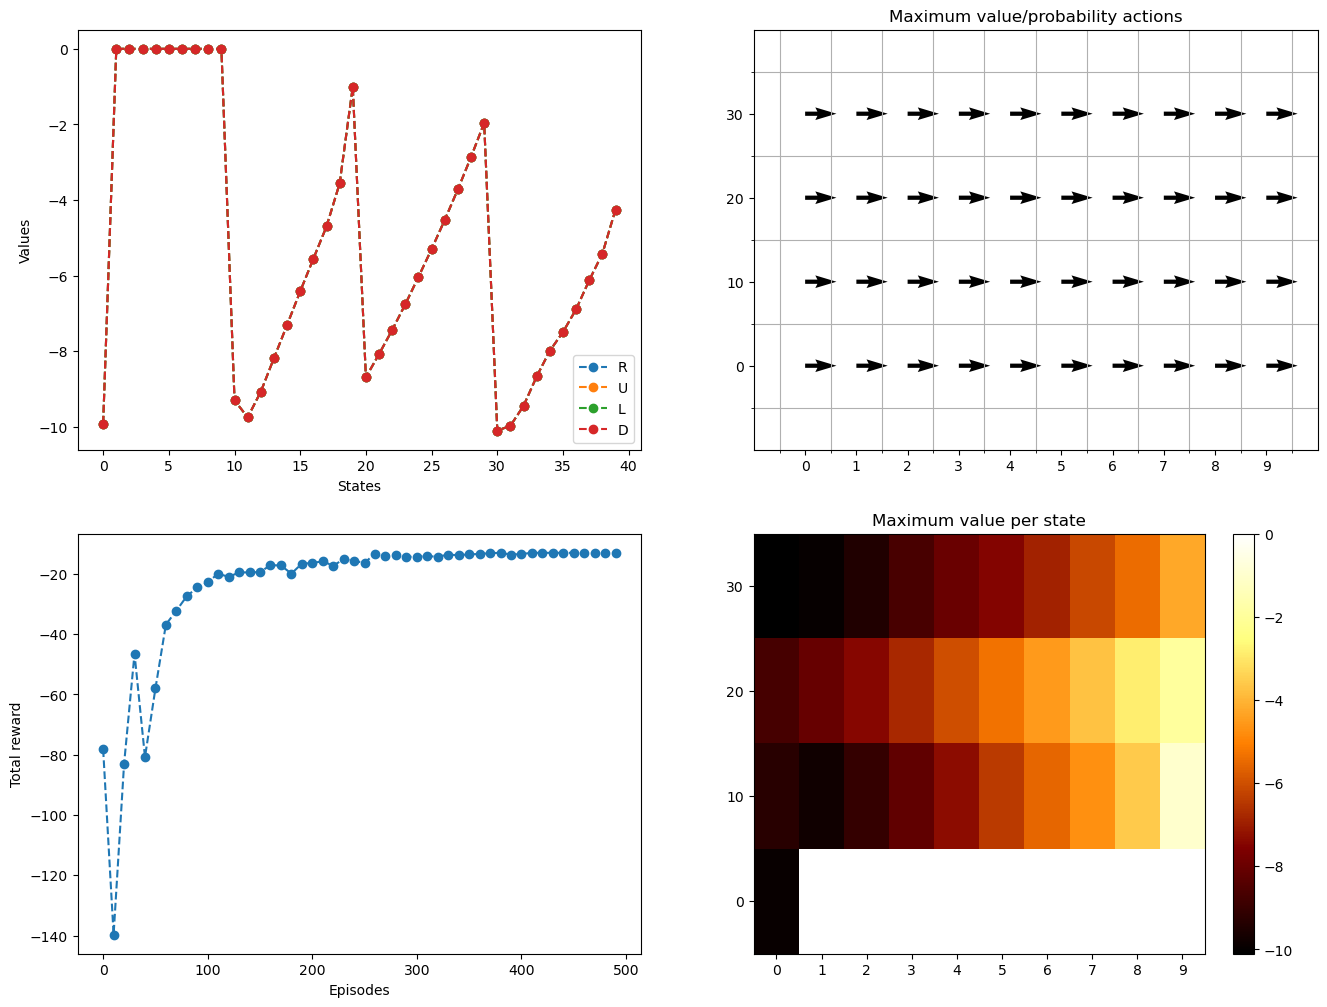

In [51]:
np.random.seed(123)
params_ac = {
    "alpha_v": 0.05,
    "alpha_pi": 0.02,
    "gamma": 0.95
}

value_ac, policy_ac, reward_sums_ac = learn_environment_actor_critic(
    env,
    learning_rule=actor_critic,
    params=params_ac,
    max_steps=200,
    n_episodes=500
)

value_2d = np.tile(value_ac[:, np.newaxis], (1, env.n_actions))

plot_performance(env, value_2d, reward_sums_ac)

#### observer comment le comportement de l'agent change.

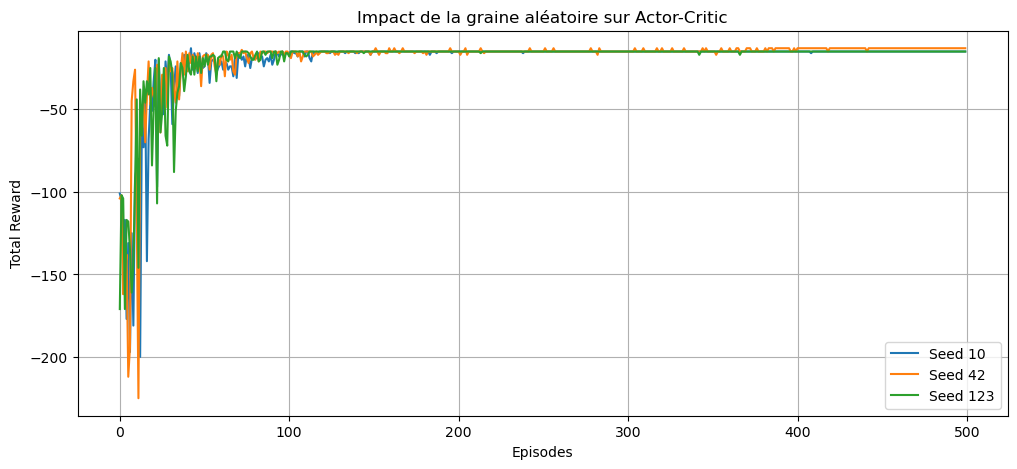

In [ ]:
import numpy as np

seeds = [10, 42, 123]  # différentes graines pour comparer le comportement

plt.figure(figsize=(12,5))

for seed in seeds:
    np.random.seed(seed)

    params_ac = {"alpha_v": 0.1, "alpha_pi": 0.05, "gamma": 0.99}
    value_ac, policy_ac, reward_sums_ac = learn_environment_actor_critic(
        env,
        learning_rule=actor_critic,
        params=params_ac,
        max_steps=200,
        n_episodes=500
    )
    value_2d = np.tile(value_ac[:, np.newaxis], (1, env.n_actions))
    plt.plot(reward_sums_ac, label=f'Seed {seed}')

plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Impact de la graine aléatoire sur Actor-Critic')
plt.legend()
plt.grid(True)
plt.show()

### Nous avons maintenant vu un exemple d'algorithmes d'apprentissage on-policy et off-polic

#### Comparez à nouveau les résultats de récompense du Q-learning et de l’actor-critic, côte à côte, pour voir comment ils se comparent.

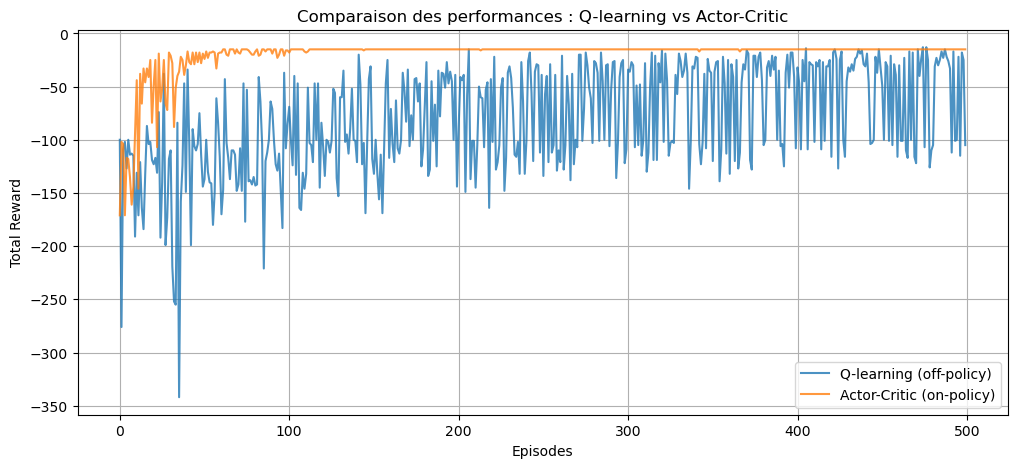

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
# Courbe Q-learning
plt.plot(reward_sums_qlearning, label='Q-learning (off-policy)', alpha=0.8)
# Courbe Actor-Critic
plt.plot(reward_sums_ac, label='Actor-Critic (on-policy)', alpha=0.8)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Comparaison des performances : Q-learning vs Actor-Critic')
plt.legend()
plt.grid(True)
plt.show()

Les deux algorithmes finissent souvent par atteindre des performances élevées dans un petit environnement discret.

Q-learning peut apparaître plus “sûr” et moins bruité, tandis qu’Actor–Critic montre plus de fluctuations mais apprend aussi directement la politique optimale, ce qui est utile si tu veux un agent capable de généraliser sa stratégie.

#### Commentez les similitudes et les différences

Q-learning est souvent plus “sûr” et stable dans les environnements simples, idéal pour des tâches discrètes avec peu d’états.

Actor–Critic est plus flexible et naturel pour les environnements continus ou stochastiques, car il apprend directement la politique, mais ses courbes peuvent être plus bruitées et moins prévisibles épisode par épisode.